Demo notebook where we will run our algorithm against test samples.

In [16]:
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


In [17]:
import sys

sys.path.append("../src")

In [18]:
%load_ext autoreload
%autoreload 2

from graph.mapping import embed_problem_to_QPU
from rdkit import Chem
from draw.features import draw_docking, draw_feature_list, draw_multiple_dockings
from draw.graph import draw_interaction_graph, draw_multiple_cliques
from graph.interaction_graph import (
    build_binding_interaction_graph,
    build_distance_matrix,
)
from mol_processing.features import name_features_by_count
from mol_processing.mol import get_features
from pulser.devices import Chadoq2
import rdkit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from solver.quantum import solver_VQAA, plot_distribution

import networkx as nx
from networkx.algorithms import approximation as approx

from pulser import Pulse, Sequence, Register

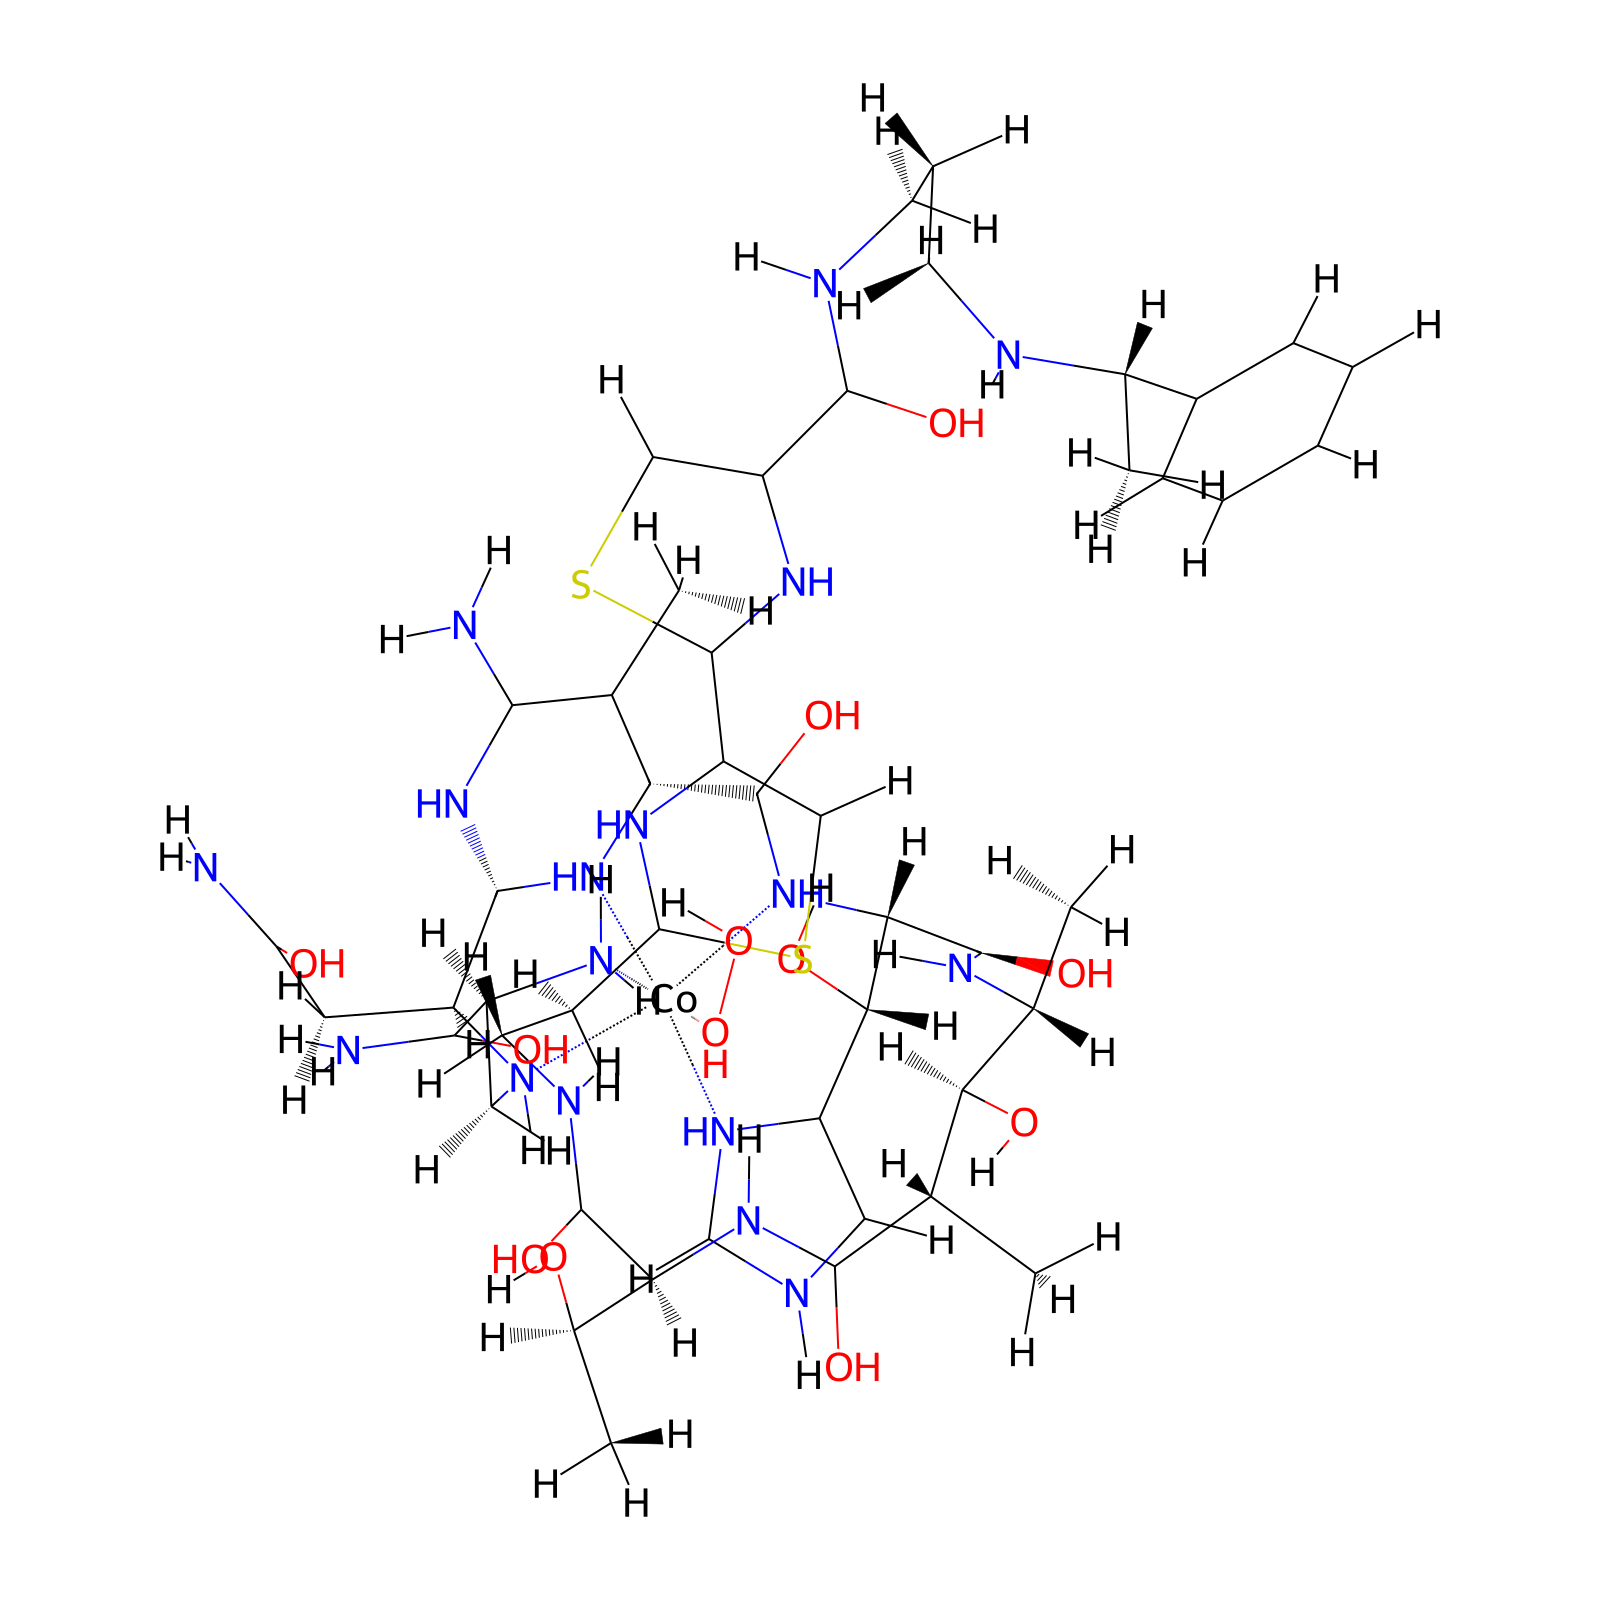

In [20]:
mol = Chem.MolFromPDBFile("../data/receptors/1AO2.pdb", sanitize=False, removeHs=False)

rdkit.Chem.Draw.MolToImage(mol, size=(1600, 1600), kekulize=True, wedgeBonds=True, fitImage=True)

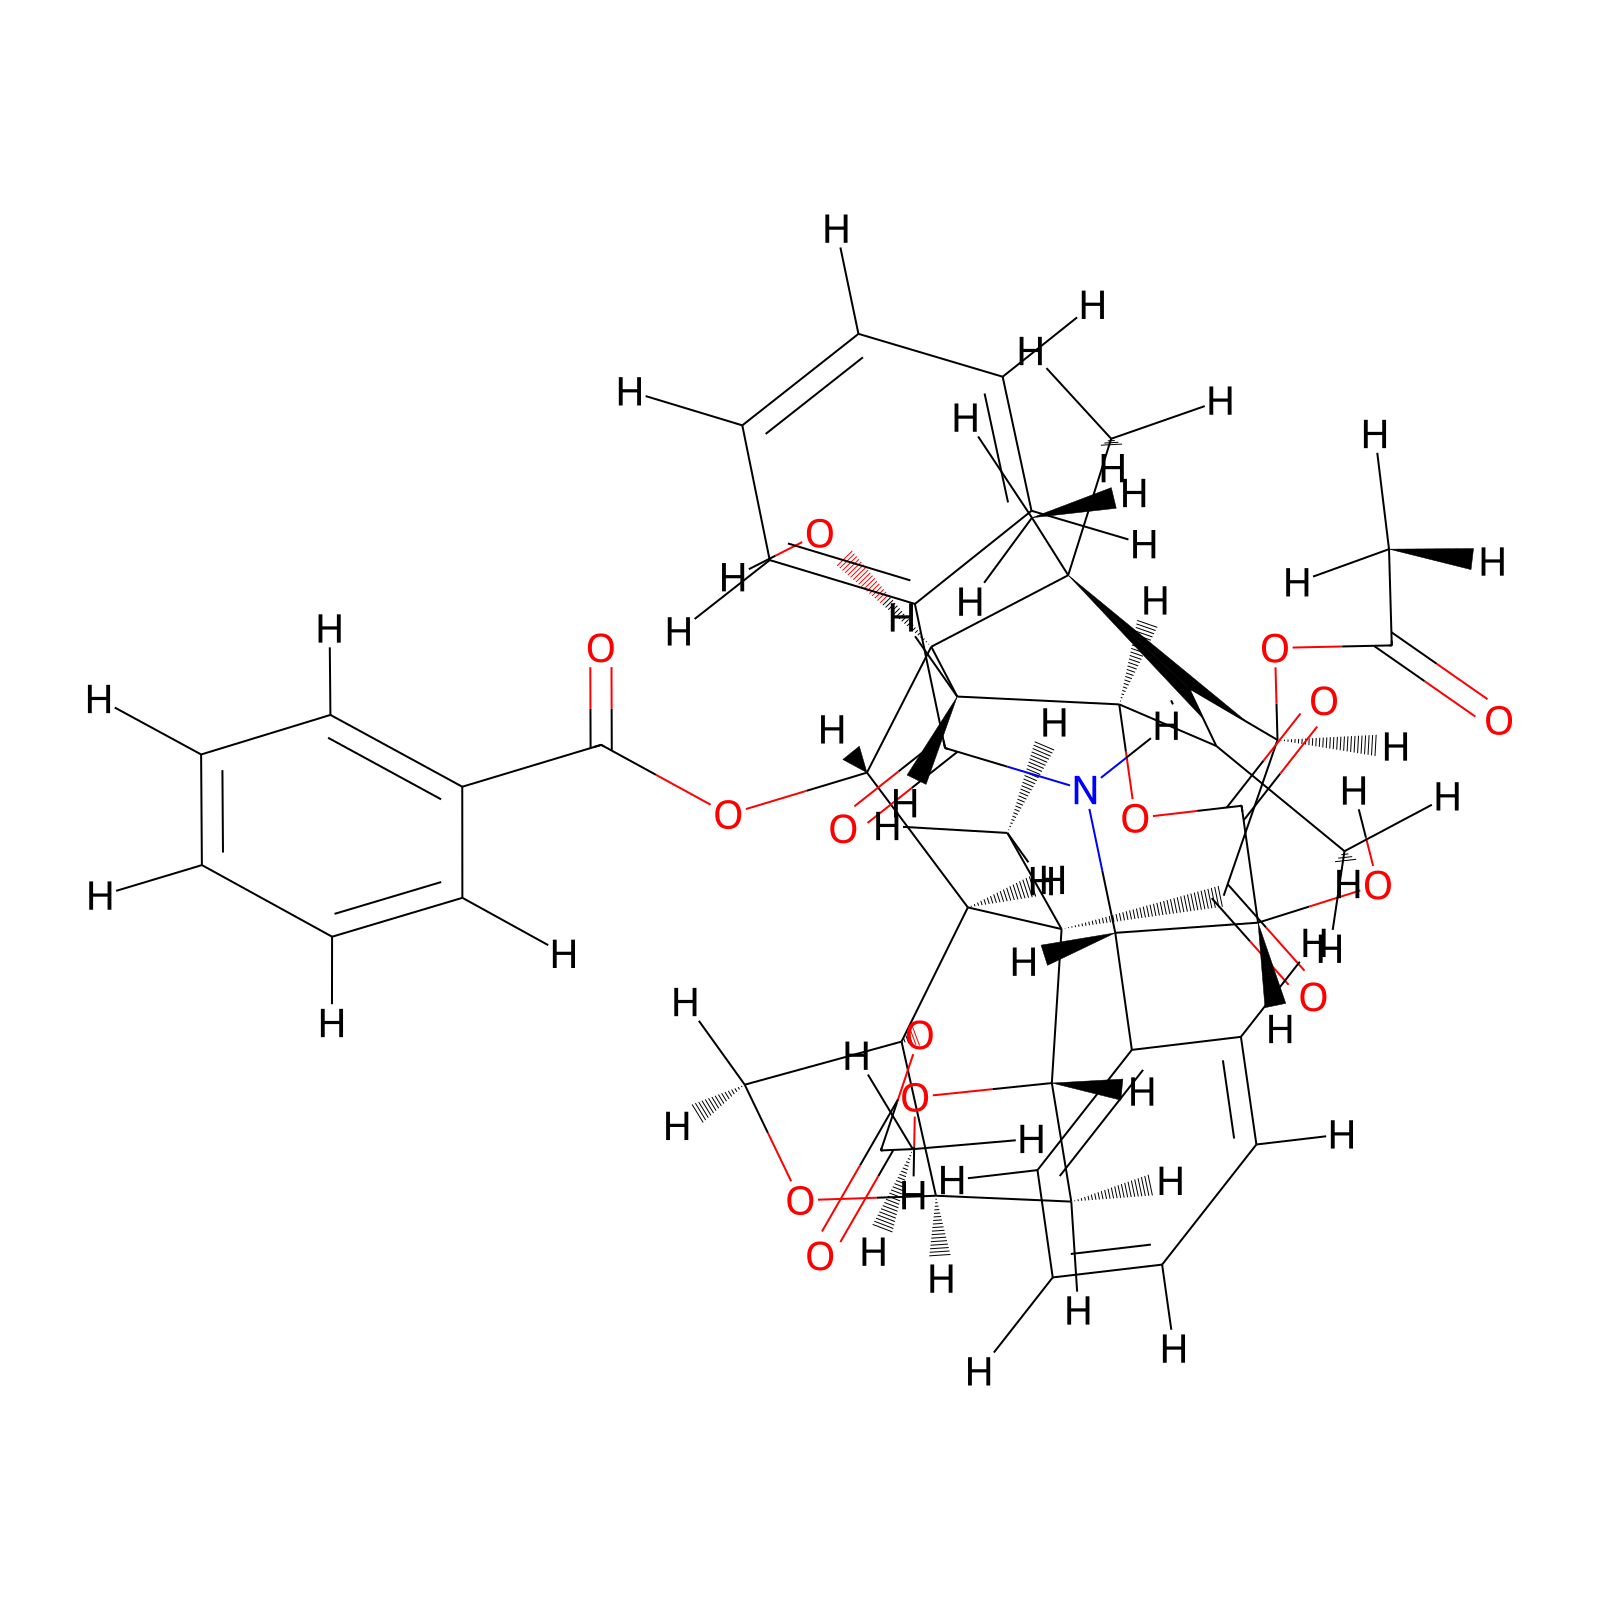

In [21]:
ligand = Chem.SDMolSupplier("../data/ligands/TAXOL.sdf", sanitize=False, removeHs=False)[0]
ligand = Chem.AddHs(ligand)
ligand.UpdatePropertyCache()
Chem.GetSymmSSSR(ligand)
ligand.GetRingInfo().NumRings()
rdkit.Chem.Draw.MolToImage(ligand, size=(1600, 1600), kekulize=True, wedgeBonds=True, fitImage=True)

2


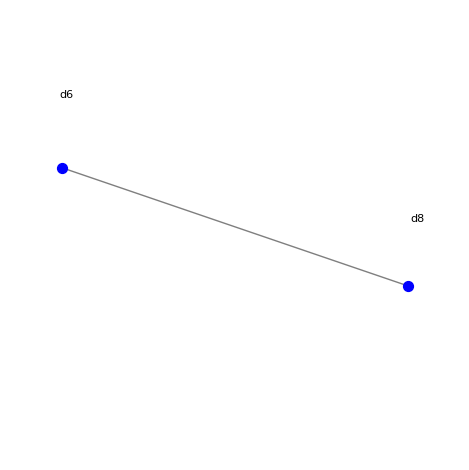

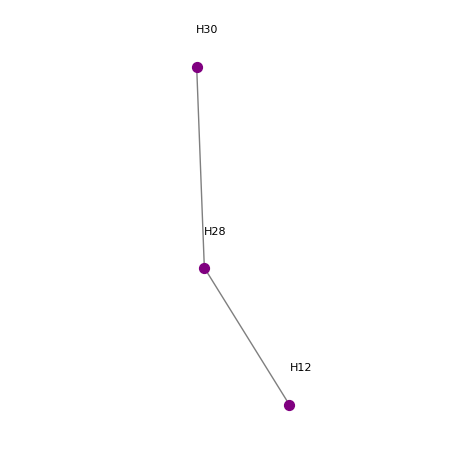

In [22]:
from mol_processing.features import spatial_selection


Chem.GetSymmSSSR(mol)
mol.GetRingInfo().NumRings()

receptor_binding_site = [(10, 15), (-10, -6), (18, 20)]
ligand_binding_site = [(0, 4), (0, 3), (2, 4)]

R_features = get_features(mol, "receptor")

L_features = get_features(ligand, "ligand")

# R_distance_matrix = build_distance_matrix(R_features)
# L_distance_matrix = build_distance_matrix(L_features)

name_features_by_count(R_features, is_ligand=False)
name_features_by_count(L_features, is_ligand=True)


# draw_feature_list(R_features, R_distance_matrix)
# draw_feature_list(L_features, L_distance_matrix)


R_features = spatial_selection(R_features, receptor_binding_site)
print(len(R_features))
L_features = spatial_selection(L_features, ligand_binding_site)


R_distance_matrix = build_distance_matrix(R_features)
L_distance_matrix = build_distance_matrix(L_features)


draw_feature_list(R_features, R_distance_matrix)
draw_feature_list(L_features, L_distance_matrix)

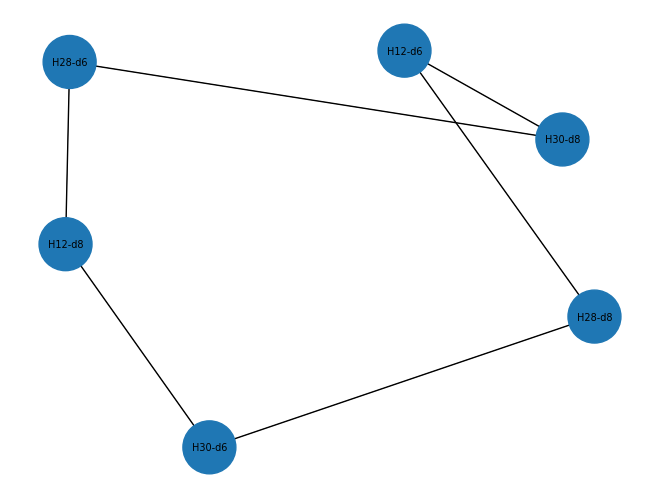

In [23]:
import networkx as nx

interaction_graph = build_binding_interaction_graph(L_distance_matrix, R_distance_matrix)
draw_interaction_graph(interaction_graph)

In [24]:
from solver.classical import find_max_clique

max_clique = find_max_clique(interaction_graph)
print(max_clique)

['H30-d6', 'H28-d8']


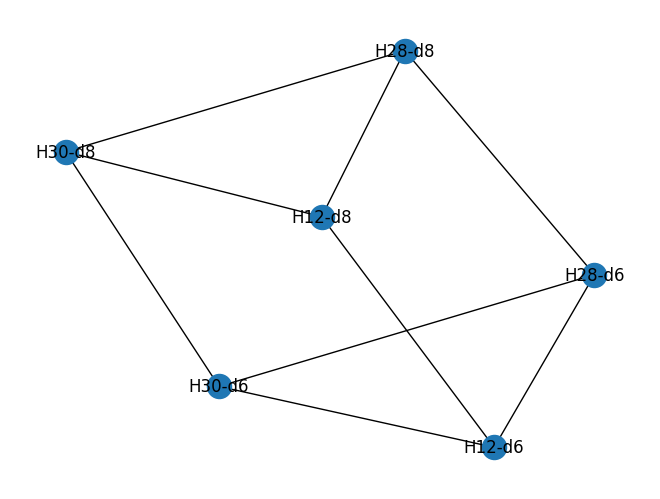

In [25]:
# MAPPING TO UDG

from graph.mapping import *

compl = build_complementary_graph(interaction_graph)
pos = nx.spring_layout(compl)  # , seed=39299899

nx.draw(
    compl,
    pos=pos,
    with_labels=True,
    node_color="tab:blue",
)

Problem while generating UDG graph: the number of resulting edges is not equal to the inital number of  edges.


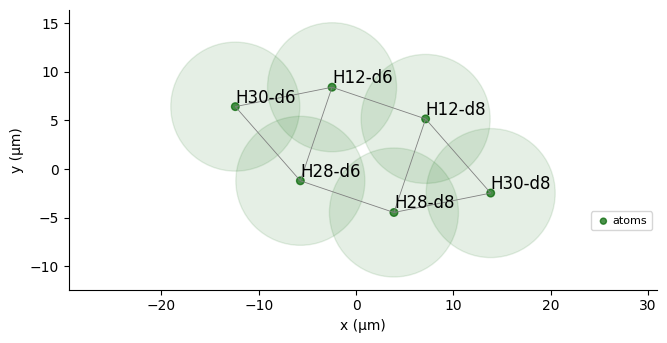

In [26]:
register = embed_problem_to_QPU(interaction_graph)

register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

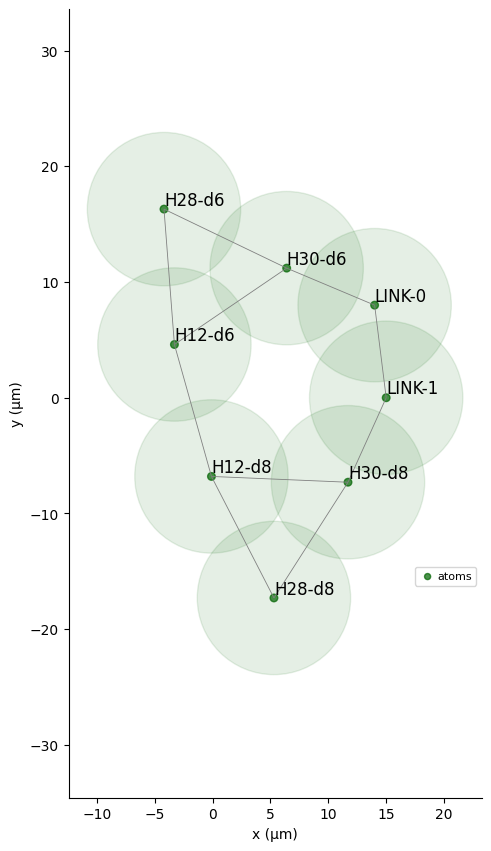

In [27]:
from graph.mapping import map_to_UDG, embed_to_register, add_quantum_link, demo_positions
from copy import deepcopy

#add_quantum_link(compl, "H30-d6", "H30-d8", 2)
# pos = map_to_UDG(linked)

add_quantum_link(compl, "H30-d6", "H30-d8", 1)

pos = demo_positions(pos)

reg = embed_to_register(pos)

reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

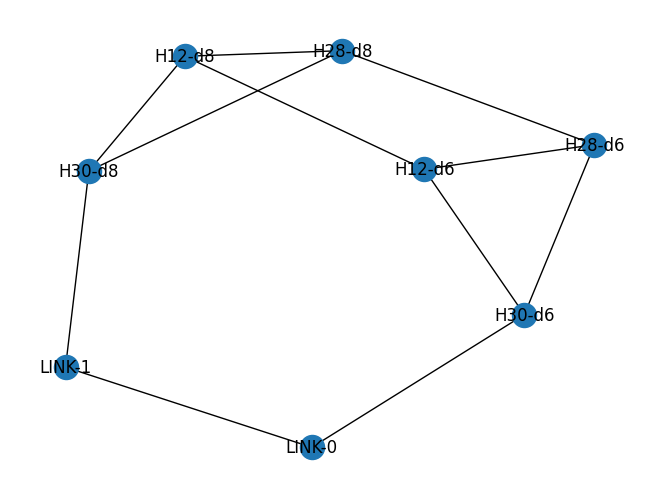

In [29]:

nx.draw(
    compl,
    with_labels=True,
    node_color="tab:blue",
)

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
# QUANTUM SOLVER
counts_solution_2, opt_param, solution_2 = solver_VQAA(reg,compl, number_best_solutions = 10, 
                                            omega_range=(0.5, 5), detuning_range=(2, 5), time_range= (15,24), repetitions = 8)

In [43]:
opt_param

array([1.56086437e+04, 3.88872681e+00, 2.91085773e+00])

In [44]:
#plot_distribution(counts_solution_2)

In [45]:
I = approx.maximum_independent_set(compl)
print(f"Maximum independent set of G: {I}")

Maximum independent set of G: {'H28-d8', 'H12-d6', 'LINK-1'}


In [46]:
solution_2

[['H28-d6', 'H28-d8', 'LINK-0'],
 ['H28-d6', 'H28-d8', 'LINK-1'],
 ['H28-d6', 'H30-d8', 'LINK-0'],
 ['H12-d6', 'H28-d8', 'LINK-0'],
 ['H28-d6', 'H12-d8', 'LINK-1'],
 ['H30-d6', 'H28-d8', 'LINK-1'],
 ['H28-d6', 'H30-d8', 'H28-d8', 'LINK-0'],
 ['H28-d6', 'H12-d8', 'LINK-0'],
 ['H12-d6', 'H28-d8', 'LINK-1'],
 ['H12-d6', 'H30-d8', 'LINK-0']]

In [12]:
#cliques = [["H2-h2", "H2-h0", "H2-h1"], ["H3-h0", "H3-h1", "H4-h4"]]

In [26]:
#draw_multiple_cliques(interaction_graph, cliques)

In [27]:
#draw_multiple_dockings(
#    L_features, L_distance_matrix, R_features, R_distance_matrix, cliques_list=cliques
#)